In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import pyroomacoustics as pra
import IPython

In [2]:
fs, signal = wavfile.read('google_speech_commands/_background_noise_/pink_noise.wav')
signal = signal[0:200000]

#? 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
# 向房间中添加信号源，并创建一个 2D 空间，并设置空间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials)。
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))
# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
# 在房间内部添加五个信号监测点： []
E_micro = np.array([[1.1], [0.55]])
room.add_microphone(E_micro)

room.add_source([0.02, 0.55], signal=signal)

room.image_source_model()
room.simulate()

In [11]:
IPython.display.Audio(signal, rate=fs)

#### 验证一：
> 为了实现使用遗传算法对 ANC 的滤波器进行进行迭代更新，需要深入理解 Pyroomacoustic 包中麦克风数据结构 ： `room.mic_array.signal`。

By calling simulate(), a convolution of the signal of each source (if not None) will be performed with the corresponding room impulse response. The output from the convolutions will be summed up at the microphones. The result is stored in the signals attribute of room.mic_array with each row corresponding to one microphone.

在调用`simulate()`后，<font color="red">将使用响应的房间脉冲响应对每个源信号进行卷积。卷积输出将在麦克风处相加。结果将存储在`room.mic_array`的`signals`属性中，并且每行对应一个麦克风。</font>

#### 验证二：
> 我原始的想法：为了验证空间脉冲响应与输入信号无关，通过下面的代码验证

<font color="red">但是仿真结果却表示同样的空间，同样空间属性，对于不同噪声的RIR却不一样！</font>

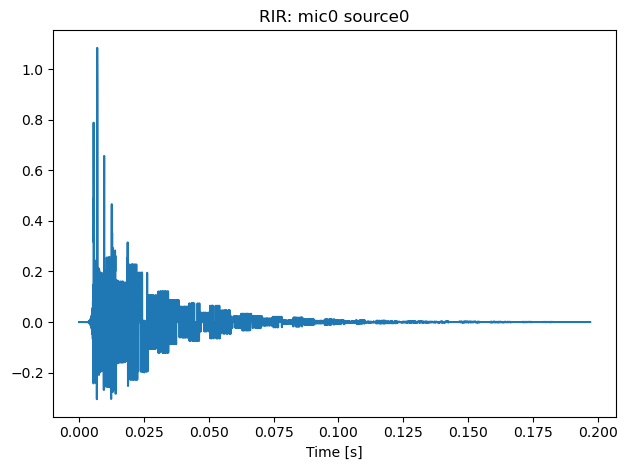

In [3]:
# 上面的room添加的是粉噪声，下面查看其RIR
# room.rir[0][0].shape
room.plot_rir()

In [4]:
# 下面输入白噪声，并查看其RIR
fs_w, signal_w = wavfile.read('google_speech_commands/_background_noise_/doing_the_dishes.wav')
signal_w = signal_w[0:200000]

#? 创建房间的节点
corners_w = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
# 向房间中添加信号源，并创建一个 2D 空间，并设置空间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials)。
room_w = pra.Room.from_corners(corners_w, fs=fs_w, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))
# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room_w.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
# 在房间内部添加五个信号监测点： []
E_micro_w = np.array([[1.1], [0.55]])
room_w.add_microphone(E_micro_w)

room_w.add_source([0.02, 0.55], signal=signal_w)

room_w.image_source_model()
room_w.simulate()

/tmp/ipykernel_17501/2061037750.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_w, signal_w = wavfile.read('google_speech_commands/_background_noise_/doing_the_dishes.wav')


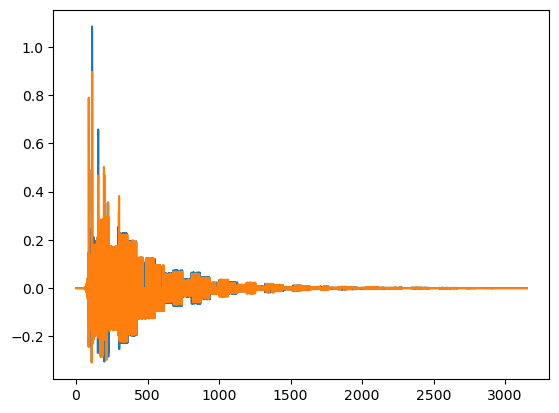

In [5]:
plt.plot(room.rir[0][0])
plt.plot(room_w.rir[0][0])

#### 验证三：

> 在设计算法的时候，由于需要逐步添加噪声信号，因此这验证整体添加噪声信号与逐步添加噪声信号对仿真结果的影响。

In [9]:
# 下面输入白噪声，并查看其RIR
fs_w_sep, signal_w_sep = wavfile.read('google_speech_commands/_background_noise_/pink_noise.wav')
signal_w_sep = signal_w_sep[0:200000]

#? 创建房间的节点
corners_w_sep = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
# 向房间中添加信号源，并创建一个 2D 空间，并设置空间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials)。
room_w_sep = pra.Room.from_corners(corners_w_sep, fs=fs_w_sep, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))
# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room_w_sep.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
# 在房间内部添加五个信号监测点： []
E_micro_w_sep = np.array([[1.1], [0.55]])
room_w_sep.add_microphone(E_micro_w_sep)

for i in range(int(len(signal_w_sep) / 2000)):
    room_w_sep.add_source([0.02, 0.55], signal=signal_w_sep[i:i+2000])
    room_w_sep.image_source_model()

# room_w.add_source([0.02, 0.55], signal=signal_w)

room_w_sep.simulate()

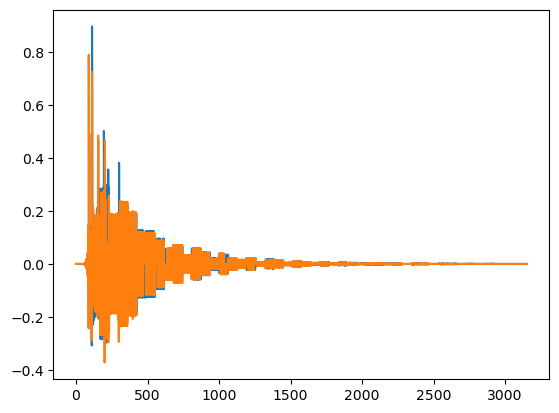

In [10]:
plt.plot(room_w.rir[0][0])
plt.plot(room_w_sep.rir[0][0])

In [8]:
room.mic_array.signals.shape
# plt.plot(room.mic_array.signals[1,:])

(1, 203152)